In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
os.chdir('C:\\Users\\steve\\OneDrive\\Data Science MSc\\MSc Project') # make sure we start right

##### Exploring the Data

In [3]:
df = pd.read_csv('THIS_IS_IT.csv')
df.tail()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
726,226399,3104,Control,M,72,1,MRI,Axial PD-T2 TSE,Original,2/14/2011,DCM,NaN
727,301554,3104,Control,M,73,5,MRI,Axial PD-T2 TSE,Original,4/20/2012,DCM,NaN
728,226366,3102,PD,M,64,1,MRI,Axial PD-T2 TSE,Original,11/23/2010,DCM,NaN
729,378210,3102,PD,M,66,7,MRI,Axial PD-T2 TSE FS,Original,02/06/2013,DCM,NaN
730,353457,3102,PD,M,65,21,MRI,Axial PD-T2 TSE,Original,11/21/2011,DCM,NaN


In [4]:
descriptions_array = df.Description.values
np.unique(descriptions_array, return_counts=True) 
# so most is Axial PD-T2 TSE and Axial PD-T2 TSE FS
# leaves us with either 292 or 356, try to find the difference

(array(['AXIAL PD-T2 TSE FS', 'Axial PD-T2 TSE', 'Axial PD-T2 TSE FS',
        'Axial PD-T2 TSE_AC PC line', 'Axial PD-T2 TSE_AC/PC line',
        'Axial PD-T2-FS TSE', 'T2'], dtype=object),
 array([ 33, 292, 356,   2,  24,  23,   1], dtype=int64))

In [5]:
# looks like a bunch of Axial PD-T2 TSE are mislabelled or slightly different, change these
dscrptn = df['Description'].replace({'Axial PD-T2-FS TSE':'Axial PD-T2 TSE FS', 'AXIAL PD-T2 TSE FS':'Axial PD-T2 TSE FS', 
                           'Axial PD-T2 TSE_AC PC line':'Axial PD-T2 TSE_AC/PC line'})

df['Description'] = dscrptn

In [6]:
np.unique(df.Description.values, return_counts=True) 
# looks about right. Now need to decide on TSE vs TSE FS
# well FS has more data, let's try to find something more substantial though

(array(['Axial PD-T2 TSE', 'Axial PD-T2 TSE FS',
        'Axial PD-T2 TSE_AC/PC line', 'T2'], dtype=object),
 array([292, 412,  26,   1], dtype=int64))

In [15]:
# We're going with the FS, more data and it looks 'cleaner'

In [19]:
df2 = df[df['Description']=='Axial PD-T2 TSE FS']
df2.head() # we can see that some patients have multiple scans and different dates, treat these as independent occurances
# Plan:
# get all the subject ID's
# Search these folders, if the folders have more than 1 subfolder, take the second, that will be the FS Files.
# Then each of the scans inside are relevant to feed into our NN

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,377981,4139,Control,M,81,1,MRI,Axial PD-T2 TSE FS,Original,04/09/2013,DCM,NaN
1,436432,4136,PD,M,57,5,MRI,Axial PD-T2 TSE FS,Original,05/06/2014,DCM,NaN
2,377973,4136,PD,M,56,1,MRI,Axial PD-T2 TSE FS,Original,2/28/2013,DCM,NaN
3,377952,4135,PD,M,67,1,MRI,Axial PD-T2 TSE FS,Original,03/01/2013,DCM,NaN
4,377945,4085,Control,M,67,1,MRI,Axial PD-T2 TSE FS,Original,04/08/2013,DCM,NaN


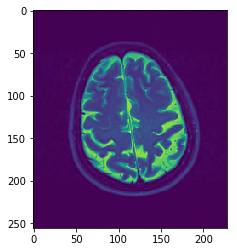

In [23]:
slices = pydicom.read_file("PPMI_3113_MR_Axial_PD-T2_TSE_FS_br_raw_20131008152954645_93_S203292_I393644.dcm")
plt.imshow(slices.pixel_array)
plt.show()

##### Changing working directory to access the images, Test a DICOM File for now

In [9]:
# have to dive into the file system to do that.. (on AWS have it all accessed on the bucketz)
import pydicom
from pydicom.data import get_testdata_files

In [21]:
# os.chdir('C:\\Users\\steve\Downloads\PPMI_THIS_IS_IT')
os.chdir('C:\\Users\\steve\Downloads')
os.getcwd()

'C:\\Users\\steve\\Downloads'

In [14]:
# pydicom.read_file("PPMI_3113_MR_Axial_PD-T2_TSE_FS_br_raw_20131008152954645_93_S203292_I393644.dcm")